In [1]:
import pandas as pd
import numpy as np
import itertools
import random
import math
from collections import defaultdict
from collections import Counter
from matplotlib import pyplot as plt

# Reading data

In [2]:
alunos = pd.read_csv('alunos.csv', sep=';')
alunos.head()

,Data,Idade,Doenca
0,21/9/2019,16,sarampo
1,19/8/2006,18,meningite
2,15/1/2011,16,meningite
3,13/2/2009,17,catapora
4,19/6/2006,18,meningite


### Separating data to generalize it when necessary

In [3]:
alunos_copy = alunos.copy()
complemento = alunos['Data'].str.split('/', expand=True)
alunos_copy['Dia'], alunos_copy['Mes'], alunos_copy['Ano'] = complemento[0], complemento[1], complemento[2]
original_data = alunos_copy['Data']
alunos_copy = alunos_copy[['Dia', 'Mes', 'Ano', 'Idade', 'Doenca']]

alunos_copy.head()

,Dia,Mes,Ano,Idade,Doenca
0,21,9,2019,16,sarampo
1,19,8,2006,18,meningite
2,15,1,2011,16,meningite
3,13,2,2009,17,catapora
4,19,6,2006,18,meningite


In [4]:
def priority(dataset):
    generalization_order = [list(dataset.columns[i:-1]) for i in range(len(dataset.columns)-2)]
    generalization_order = [dataset.groupby(generalization_order[i]).groups for i in range(len(generalization_order))]

    return generalization_order

def initial_clusters(dataset, k):
    clusters = defaultdict(list)
    clustered = set()
    generalization_order = priority(dataset)

    for i in range(len(generalization_order)):
        for key, value in zip(generalization_order[i].keys(), generalization_order[i].values()):
            if len(value) >= k and len(clustered.intersection(value)) == 0:
                # se o grupo do groupby é maior ou igual a k e nenhum dos valores já estiver agrupado
                clusters[key] = list(itertools.chain(value))
                clustered = clustered.union(clusters[key])
                
    return clusters, clustered

In [5]:
def clustering_remaining_tuples(separated_dataset, clusters, clustered, k):
    # Agrupar por década e intervalo de idade
    not_clustered = list(set(separated_dataset.index) - set(clustered))
    not_clustered_df = separated_dataset.loc[not_clustered]
    
    decades = [ano[:-1]+'0s' for ano in not_clustered_df['Ano']]
    
    not_clustered_df['Idade'] = not_clustered_df['Idade'].astype(str)
    not_clustered_df['FaixaEtaria'] = [None]*len(not_clustered_df)

    for i in range(len(not_clustered_df['Idade'])):
        if(int(not_clustered_df['Idade'].iloc[i][-1]) >= 5):
            not_clustered_df['FaixaEtaria'].iloc[i] = not_clustered_df['Idade'].iloc[i][0]+'5-'+not_clustered_df['Idade'].iloc[i][0]+'9'
        else:
            not_clustered_df['FaixaEtaria'].iloc[i] = not_clustered_df['Idade'].iloc[i][0]+'0-'+not_clustered_df['Idade'].iloc[i][0]+'4'

    not_clustered_df['Decada'] = decades

    not_clustered_df = not_clustered_df[['Decada', 'FaixaEtaria', 'Doenca']]

    remaining_clusters, remaining_clustered = initial_clusters(not_clustered_df, k)
    clustered = clustered.union(remaining_clustered)
   
    for key, value in zip(remaining_clusters.keys(), remaining_clusters.values()):
        clusters[key] = value
        
    return clusters

# k-anonimato

In [6]:
def k_anonymity(dataset, clusters):
    k_anonymized = pd.DataFrame([[None]*3]*len(dataset), columns=dataset.columns)
    for key, value in zip(clusters.keys(), clusters.values()):
        if not isinstance(key, list) and isinstance(key, str):
            if '-' not in key:
                k_anonymized.loc[value] = [[key, '{}-{}'.format(dataset['Idade'].min(), dataset['Idade'].max()), key]+[dataset[dataset.columns[-1]].loc[v]] for v in value]
        
        if all(map(lambda x: isinstance(x, str), key)):
            k_anonymized.loc[value] = [[k for k in key]+[dataset[dataset.columns[-1]].loc[v]] for v in value]

        else:
            to_fill = [key[0]]
            for i in range(1, len(key)):
                if type(key[i]) == str:
                    to_fill[0] = to_fill[0] + str('/'+key[i])
                else:
                    to_fill.append(key[i])
            k_anonymized.loc[value] = [to_fill+[dataset[dataset.columns[-1]].loc[v]] for v in value]

    return k_anonymized

In [7]:
def plot_histogram(clusters):
    lengths = []
    for cluster in clusters.values():
        lengths.append(len(cluster))

    counter = dict(sorted(Counter(lengths).items()))
    keys_str = [str(key) for key in counter.keys()]
    plt.bar(keys_str, counter.values())
    
    return plt.show()

### Cálculo da precisão

In [8]:
def len_HGV(atrib):
    if(atrib == 'Data'):
        return 4
    elif(atrib == 'Idade'):
        return 3
    else:
        return 'Atributo inválido.'
    
def level_tree(atrib, input_):
    if(atrib == 'Data'):
        if('s' in input_):
            return 4
        elif(input_.count('/') == 0):
            return 3
        elif(input_.count('/') == 1):
            return 2
        else:
            return 1
    elif(atrib == 'Idade'):
        if(type(input_) == int):
            return 1
        elif(type(input_) == str and (input_ == '15-19' or input_ == '20-24')):
            return 2
        else:
            return 3
    else:
        return "Atributo inválido."
    
def precision(dataset):
    dataset = anon.copy()
    sum_all = 0
    for at in dataset.columns[:-1]:
        sum_reg = 0
        for value in dataset[at]: # percorre o dataset e pega os valores de tal atributo
            sum_reg += level_tree(at, value)
        sum_all += sum_reg/len_HGV(at)

    return 1-(sum_all/(len(dataset)*len(dataset.columns[:-1])))

# Chamadas de funções

LEN 300

Primeiras 5 linhas do dataset anonimizado com k = 2




,Data,Idade,Doenca
0,2019,16,sarampo
1,8/2006,18,meningite
2,1/2011,16,meningite
3,2/2009,17,catapora
4,2000s,15-19,meningite


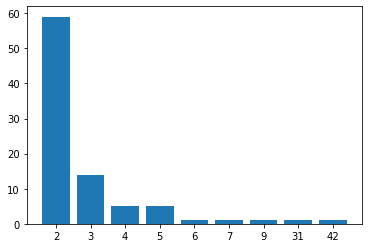

Chaves das classes de equivalência:
[('1/2011', 16), ('1/2014', 20), ('1/2015', 19), ('10/2006', 19), ('10/2012', 19), ('11/2007', 19), ('11/2017', 16), ('11/2019', 19), ('2/2005', 18), ('2/2006', 16), ('2/2009', 17), ('2/2012', 19), ('2/2015', 20), ('2000s', '15-19'), ('2000s', '20-24'), ('2005', 16), ('2005', 19), ('2005', 20), ('2006', 17), ('2007', 20), ('2008', 16), ('2008', 17), ('2008', 20), ('2009', 18), ('2010', 16), ('2010', 17), ('2010', 18), ('2010', 19), ('2010s', '15-19'), ('2010s', '20-24'), ('2011', 17), ('2011', 19), ('2011', 20), ('2012', 17), ('2012', 18), ('2013', 17), ('2013', 19), ('2013', 20), ('2014', 19), ('2016', 17), ('2016', 19), ('2016', 20), ('2017', 17), ('2017', 19), ('2017', 20), ('2018', 19), ('2019', 16), ('2019', 17), ('2019', 18), ('2019', 20), ('3/2007', 17), ('3/2007', 19), ('3/2013', 18), ('3/2015', 17), ('3/2017', 18), ('3/2018', 16), ('4/2005', 18), ('4/2009', 20), ('4/2012', 16), ('4/2014', 20), ('4/2018', 17), ('5/2006', 19), ('5/2009', 16), 

,Data,Idade,Doenca
0,2010s,15-19,sarampo
1,2006,18,meningite
2,2011,16,meningite
3,2009,17,catapora
4,2006,18,meningite


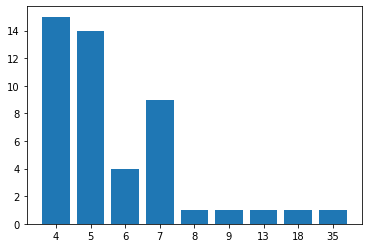

Chaves das classes de equivalência:
[('2000s', '15-19'), ('2000s', '20-24'), ('2005', 16), ('2005', 18), ('2005', 19), ('2005', 20), ('2006', 16), ('2006', 18), ('2006', 19), ('2006', 20), ('2007', 18), ('2007', 19), ('2008', 17), ('2008', 18), ('2008', 19), ('2009', 16), ('2009', 17), ('2009', 19), ('2009', 20), ('2010', 17), ('2010s', '15-19'), ('2010s', '20-24'), ('2011', 16), ('2011', 18), ('2011', 19), ('2012', 16), ('2012', 17), ('2012', 19), ('2013', 18), ('2014', 17), ('2014', 18), ('2014', 19), ('2014', 20), ('2015', 16), ('2015', 17), ('2015', 18), ('2015', 19), ('2015', 20), ('2016', 17), ('2016', 19), ('2017', 16), ('2017', 18), ('2018', 16), ('2018', 17), ('2018', 18), ('2019', 18), ('2019', 19)]


Precisão: 0.38930555555555557


Tamanho médio das classes de equivalência: 6.382978723404255

----------------------------------------------------------------------------------------------------

LEN 300

Primeiras 5 linhas do dataset anonimizado com k = 8




,Data,Idade,Doenca
0,2010s,15-19,sarampo
1,2000s,15-19,meningite
2,2010s,15-19,meningite
3,2000s,15-19,catapora
4,2000s,15-19,meningite


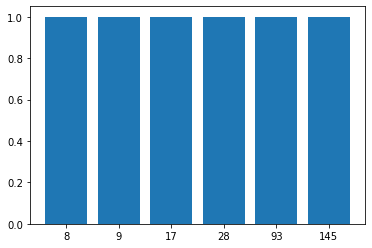

Chaves das classes de equivalência:
[('2000s', '15-19'), ('2000s', '20-24'), ('2009', 20), ('2010s', '15-19'), ('2010s', '20-24'), ('2012', 19)]


Precisão: 0.18319444444444433


Tamanho médio das classes de equivalência: 50.0

----------------------------------------------------------------------------------------------------



In [9]:
possible_k = [2, 4, 8]
for k in possible_k:
    clusters, clustered = initial_clusters(alunos_copy, k)
    all_clusters = clustering_remaining_tuples(alunos_copy, clusters, clustered, k)
    anon = k_anonymity(alunos, all_clusters)
    print('LEN',len(anon))
    print("\nPrimeiras 5 linhas do dataset anonimizado com k = {}\n\n".format(k))
    display(anon.head())
    plot_histogram(all_clusters)
    print("Chaves das classes de equivalência:\n{}\n".format(list(anon.groupby(['Data', 'Idade']).groups.keys())))
    print("\nPrecisão: {}\n\n".format(precision(anon)))
    print("Tamanho médio das classes de equivalência: {}\n\n{}\n".format(len(alunos)/len(anon.groupby(by=['Data', 'Idade']).groups), '-'*100))
    anon.to_csv('{}AnonAlunos.csv'.format(k))

# l-diversidade

In [10]:
def l_diversity(dataset_, l, label):
    dataset = dataset_.copy()
    count_labels = Counter(dataset[label])

    groups = dataset.groupby(list(dataset.columns[:-1])).groups
    
    for key in groups.keys():
        df = pd.DataFrame([dataset.loc[i] for i in groups[key]])
        if l > len(df):
            print('Valor de l inválido.')
        elif len(np.unique(df[label])) < l:
            while len(np.unique(df[label])) < l:
                display(df)
                copia_count = count_labels.copy()
                most_frequent = list(df[label].value_counts().keys())[0]
                to_change = df[df[label] == most_frequent].iloc[0].name
                # retiro a possibilidade de colocar elementos que ja estão no df[label]
                for _ in np.unique(df[label]):
                    copia_count.pop(_)
                print(copia_count)
                df[label].loc[to_change] = random.choices(list(copia_count.keys()), weights=copia_count.values(), k=1)[0]
                display(df)
        for i in df.index:
            dataset.loc[i] = df.loc[i]       
    return dataset

### Cálculo do erro absoluto l-diversidade

In [11]:
def absolute_error(dataset_original, dataset_anon, label):
    count_labels_orig = Counter(dataset_original[label])
    count_labels_anon = Counter(dataset_anon[label])

    errors = []

    for doenca in count_labels_orig:
        errors.append(abs(count_labels_orig[doenca] - count_labels_anon[doenca]))

    return list(count_labels_anon.keys()), errors

# Chamada de funções l-diversidade

In [14]:
clusters, clustered = initial_clusters(alunos_copy, 8)
all_clusters = clustering_remaining_tuples(alunos_copy, clusters, clustered, 8)
df_k_anon = k_anonymity(alunos, all_clusters)
groups_k_anon = df_k_anon.groupby(['Data', 'Idade']).groups

possible_l = [2, 3, 4]

for l in possible_l:
    anon = l_diversity(anon, l, 'Doenca')
    print("\nl = {}\n\n".format(l))
    groups = anon.groupby(['Data', 'Idade']).groups
    [(print('\n\nDataset antes e após aplicar {}-diversidade.\n\n'.format(l)), display(pd.DataFrame([anon.loc[i] for i in values]).sort_values(by='Doenca')), display(pd.DataFrame([df_k_anon.loc[i] for i in values]).sort_values(by='Doenca'))) \
     for values in groups.values()]
    print('Erro Absoluto: {}\n\n'.format(absolute_error(alunos, anon, 'Doenca')))
    print("Tamanho médio das classes de equivalência: {}\n\n{}\n".format(len(alunos)/len(anon.groupby(by=['Data', 'Idade']).groups), '-'*100))
    anon.to_csv('{}lAnonAlunos.csv'.format(l))


l = 2




Dataset antes e após aplicar 2-diversidade.




,Data,Idade,Doenca
152,2000s,15-19,catapora
65,2000s,15-19,catapora
69,2000s,15-19,catapora
79,2000s,15-19,catapora
251,2000s,15-19,catapora
...,...,...,...
297,2000s,15-19,sarampo
160,2000s,15-19,sarampo
161,2000s,15-19,sarampo
84,2000s,15-19,sarampo


,Data,Idade,Doenca
152,2000s,15-19,catapora
65,2000s,15-19,catapora
69,2000s,15-19,catapora
79,2000s,15-19,catapora
251,2000s,15-19,catapora
...,...,...,...
297,2000s,15-19,sarampo
160,2000s,15-19,sarampo
161,2000s,15-19,sarampo
84,2000s,15-19,sarampo




Dataset antes e após aplicar 2-diversidade.




,Data,Idade,Doenca
190,2000s,20-24,catapora
206,2000s,20-24,catapora
98,2000s,20-24,catapora
99,2000s,20-24,catapora
198,2000s,20-24,catapora
146,2000s,20-24,catapora
246,2000s,20-24,catapora
220,2000s,20-24,gripe
13,2000s,20-24,gripe
140,2000s,20-24,meningite


,Data,Idade,Doenca
190,2000s,20-24,catapora
206,2000s,20-24,catapora
98,2000s,20-24,catapora
99,2000s,20-24,catapora
198,2000s,20-24,catapora
146,2000s,20-24,catapora
246,2000s,20-24,catapora
220,2000s,20-24,gripe
13,2000s,20-24,gripe
140,2000s,20-24,meningite




Dataset antes e após aplicar 2-diversidade.




,Data,Idade,Doenca
77,2009,20,catapora
158,2009,20,gripe
210,2009,20,gripe
120,2009,20,meningite
149,2009,20,meningite
207,2009,20,meningite
93,2009,20,sarampo
142,2009,20,sarampo


,Data,Idade,Doenca
77,2009,20,catapora
158,2009,20,gripe
210,2009,20,gripe
120,2009,20,meningite
149,2009,20,meningite
207,2009,20,meningite
93,2009,20,sarampo
142,2009,20,sarampo




Dataset antes e após aplicar 2-diversidade.




,Data,Idade,Doenca
113,2010s,15-19,catapora
249,2010s,15-19,catapora
148,2010s,15-19,catapora
156,2010s,15-19,catapora
174,2010s,15-19,catapora
...,...,...,...
133,2010s,15-19,sarampo
123,2010s,15-19,sarampo
112,2010s,15-19,sarampo
183,2010s,15-19,sarampo


,Data,Idade,Doenca
113,2010s,15-19,catapora
249,2010s,15-19,catapora
148,2010s,15-19,catapora
156,2010s,15-19,catapora
174,2010s,15-19,catapora
...,...,...,...
133,2010s,15-19,sarampo
123,2010s,15-19,sarampo
112,2010s,15-19,sarampo
183,2010s,15-19,sarampo




Dataset antes e após aplicar 2-diversidade.




,Data,Idade,Doenca
294,2010s,20-24,catapora
276,2010s,20-24,catapora
14,2010s,20-24,catapora
194,2010s,20-24,catapora
58,2010s,20-24,catapora
288,2010s,20-24,catapora
273,2010s,20-24,gripe
182,2010s,20-24,gripe
106,2010s,20-24,gripe
147,2010s,20-24,gripe


,Data,Idade,Doenca
294,2010s,20-24,catapora
276,2010s,20-24,catapora
14,2010s,20-24,catapora
194,2010s,20-24,catapora
58,2010s,20-24,catapora
288,2010s,20-24,catapora
273,2010s,20-24,gripe
182,2010s,20-24,gripe
106,2010s,20-24,gripe
147,2010s,20-24,gripe




Dataset antes e após aplicar 2-diversidade.




,Data,Idade,Doenca
242,2012,19,catapora
118,2012,19,gripe
60,2012,19,meningite
144,2012,19,meningite
175,2012,19,meningite
299,2012,19,meningite
33,2012,19,sarampo
36,2012,19,sarampo
278,2012,19,sarampo


,Data,Idade,Doenca
242,2012,19,catapora
118,2012,19,gripe
60,2012,19,meningite
144,2012,19,meningite
175,2012,19,meningite
299,2012,19,meningite
33,2012,19,sarampo
36,2012,19,sarampo
278,2012,19,sarampo


Erro Absoluto: (['sarampo', 'meningite', 'catapora', 'gripe'], [0, 0, 0, 0])


Tamanho médio das classes de equivalência: 50.0

----------------------------------------------------------------------------------------------------


l = 3




Dataset antes e após aplicar 3-diversidade.




,Data,Idade,Doenca
152,2000s,15-19,catapora
65,2000s,15-19,catapora
69,2000s,15-19,catapora
79,2000s,15-19,catapora
251,2000s,15-19,catapora
...,...,...,...
297,2000s,15-19,sarampo
160,2000s,15-19,sarampo
161,2000s,15-19,sarampo
84,2000s,15-19,sarampo


,Data,Idade,Doenca
152,2000s,15-19,catapora
65,2000s,15-19,catapora
69,2000s,15-19,catapora
79,2000s,15-19,catapora
251,2000s,15-19,catapora
...,...,...,...
297,2000s,15-19,sarampo
160,2000s,15-19,sarampo
161,2000s,15-19,sarampo
84,2000s,15-19,sarampo




Dataset antes e após aplicar 3-diversidade.




,Data,Idade,Doenca
190,2000s,20-24,catapora
206,2000s,20-24,catapora
98,2000s,20-24,catapora
99,2000s,20-24,catapora
198,2000s,20-24,catapora
146,2000s,20-24,catapora
246,2000s,20-24,catapora
220,2000s,20-24,gripe
13,2000s,20-24,gripe
140,2000s,20-24,meningite


,Data,Idade,Doenca
190,2000s,20-24,catapora
206,2000s,20-24,catapora
98,2000s,20-24,catapora
99,2000s,20-24,catapora
198,2000s,20-24,catapora
146,2000s,20-24,catapora
246,2000s,20-24,catapora
220,2000s,20-24,gripe
13,2000s,20-24,gripe
140,2000s,20-24,meningite




Dataset antes e após aplicar 3-diversidade.




,Data,Idade,Doenca
77,2009,20,catapora
158,2009,20,gripe
210,2009,20,gripe
120,2009,20,meningite
149,2009,20,meningite
207,2009,20,meningite
93,2009,20,sarampo
142,2009,20,sarampo


,Data,Idade,Doenca
77,2009,20,catapora
158,2009,20,gripe
210,2009,20,gripe
120,2009,20,meningite
149,2009,20,meningite
207,2009,20,meningite
93,2009,20,sarampo
142,2009,20,sarampo




Dataset antes e após aplicar 3-diversidade.




,Data,Idade,Doenca
113,2010s,15-19,catapora
249,2010s,15-19,catapora
148,2010s,15-19,catapora
156,2010s,15-19,catapora
174,2010s,15-19,catapora
...,...,...,...
133,2010s,15-19,sarampo
123,2010s,15-19,sarampo
112,2010s,15-19,sarampo
183,2010s,15-19,sarampo


,Data,Idade,Doenca
113,2010s,15-19,catapora
249,2010s,15-19,catapora
148,2010s,15-19,catapora
156,2010s,15-19,catapora
174,2010s,15-19,catapora
...,...,...,...
133,2010s,15-19,sarampo
123,2010s,15-19,sarampo
112,2010s,15-19,sarampo
183,2010s,15-19,sarampo




Dataset antes e após aplicar 3-diversidade.




,Data,Idade,Doenca
294,2010s,20-24,catapora
276,2010s,20-24,catapora
14,2010s,20-24,catapora
194,2010s,20-24,catapora
58,2010s,20-24,catapora
288,2010s,20-24,catapora
273,2010s,20-24,gripe
182,2010s,20-24,gripe
106,2010s,20-24,gripe
147,2010s,20-24,gripe


,Data,Idade,Doenca
294,2010s,20-24,catapora
276,2010s,20-24,catapora
14,2010s,20-24,catapora
194,2010s,20-24,catapora
58,2010s,20-24,catapora
288,2010s,20-24,catapora
273,2010s,20-24,gripe
182,2010s,20-24,gripe
106,2010s,20-24,gripe
147,2010s,20-24,gripe




Dataset antes e após aplicar 3-diversidade.




,Data,Idade,Doenca
242,2012,19,catapora
118,2012,19,gripe
60,2012,19,meningite
144,2012,19,meningite
175,2012,19,meningite
299,2012,19,meningite
33,2012,19,sarampo
36,2012,19,sarampo
278,2012,19,sarampo


,Data,Idade,Doenca
242,2012,19,catapora
118,2012,19,gripe
60,2012,19,meningite
144,2012,19,meningite
175,2012,19,meningite
299,2012,19,meningite
33,2012,19,sarampo
36,2012,19,sarampo
278,2012,19,sarampo


Erro Absoluto: (['sarampo', 'meningite', 'catapora', 'gripe'], [0, 0, 0, 0])


Tamanho médio das classes de equivalência: 50.0

----------------------------------------------------------------------------------------------------


l = 4




Dataset antes e após aplicar 4-diversidade.




,Data,Idade,Doenca
152,2000s,15-19,catapora
65,2000s,15-19,catapora
69,2000s,15-19,catapora
79,2000s,15-19,catapora
251,2000s,15-19,catapora
...,...,...,...
297,2000s,15-19,sarampo
160,2000s,15-19,sarampo
161,2000s,15-19,sarampo
84,2000s,15-19,sarampo


,Data,Idade,Doenca
152,2000s,15-19,catapora
65,2000s,15-19,catapora
69,2000s,15-19,catapora
79,2000s,15-19,catapora
251,2000s,15-19,catapora
...,...,...,...
297,2000s,15-19,sarampo
160,2000s,15-19,sarampo
161,2000s,15-19,sarampo
84,2000s,15-19,sarampo




Dataset antes e após aplicar 4-diversidade.




,Data,Idade,Doenca
190,2000s,20-24,catapora
206,2000s,20-24,catapora
98,2000s,20-24,catapora
99,2000s,20-24,catapora
198,2000s,20-24,catapora
146,2000s,20-24,catapora
246,2000s,20-24,catapora
220,2000s,20-24,gripe
13,2000s,20-24,gripe
140,2000s,20-24,meningite


,Data,Idade,Doenca
190,2000s,20-24,catapora
206,2000s,20-24,catapora
98,2000s,20-24,catapora
99,2000s,20-24,catapora
198,2000s,20-24,catapora
146,2000s,20-24,catapora
246,2000s,20-24,catapora
220,2000s,20-24,gripe
13,2000s,20-24,gripe
140,2000s,20-24,meningite




Dataset antes e após aplicar 4-diversidade.




,Data,Idade,Doenca
77,2009,20,catapora
158,2009,20,gripe
210,2009,20,gripe
120,2009,20,meningite
149,2009,20,meningite
207,2009,20,meningite
93,2009,20,sarampo
142,2009,20,sarampo


,Data,Idade,Doenca
77,2009,20,catapora
158,2009,20,gripe
210,2009,20,gripe
120,2009,20,meningite
149,2009,20,meningite
207,2009,20,meningite
93,2009,20,sarampo
142,2009,20,sarampo




Dataset antes e após aplicar 4-diversidade.




,Data,Idade,Doenca
113,2010s,15-19,catapora
249,2010s,15-19,catapora
148,2010s,15-19,catapora
156,2010s,15-19,catapora
174,2010s,15-19,catapora
...,...,...,...
133,2010s,15-19,sarampo
123,2010s,15-19,sarampo
112,2010s,15-19,sarampo
183,2010s,15-19,sarampo


,Data,Idade,Doenca
113,2010s,15-19,catapora
249,2010s,15-19,catapora
148,2010s,15-19,catapora
156,2010s,15-19,catapora
174,2010s,15-19,catapora
...,...,...,...
133,2010s,15-19,sarampo
123,2010s,15-19,sarampo
112,2010s,15-19,sarampo
183,2010s,15-19,sarampo




Dataset antes e após aplicar 4-diversidade.




,Data,Idade,Doenca
294,2010s,20-24,catapora
276,2010s,20-24,catapora
14,2010s,20-24,catapora
194,2010s,20-24,catapora
58,2010s,20-24,catapora
288,2010s,20-24,catapora
273,2010s,20-24,gripe
182,2010s,20-24,gripe
106,2010s,20-24,gripe
147,2010s,20-24,gripe


,Data,Idade,Doenca
294,2010s,20-24,catapora
276,2010s,20-24,catapora
14,2010s,20-24,catapora
194,2010s,20-24,catapora
58,2010s,20-24,catapora
288,2010s,20-24,catapora
273,2010s,20-24,gripe
182,2010s,20-24,gripe
106,2010s,20-24,gripe
147,2010s,20-24,gripe




Dataset antes e após aplicar 4-diversidade.




,Data,Idade,Doenca
242,2012,19,catapora
118,2012,19,gripe
60,2012,19,meningite
144,2012,19,meningite
175,2012,19,meningite
299,2012,19,meningite
33,2012,19,sarampo
36,2012,19,sarampo
278,2012,19,sarampo


,Data,Idade,Doenca
242,2012,19,catapora
118,2012,19,gripe
60,2012,19,meningite
144,2012,19,meningite
175,2012,19,meningite
299,2012,19,meningite
33,2012,19,sarampo
36,2012,19,sarampo
278,2012,19,sarampo


Erro Absoluto: (['sarampo', 'meningite', 'catapora', 'gripe'], [0, 0, 0, 0])


Tamanho médio das classes de equivalência: 50.0

----------------------------------------------------------------------------------------------------

